# Dirichlet Process Clustering

In [1]:
using Gen
using Statistics
using PyPlot

┌ Info: Recompiling stale cache file /home/dmerrell/.julia/compiled/v1.2/Gen/OEZG1.ji for Gen [ea4f424c-a589-11e8-07c0-fd5c91b9da4a]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /home/dmerrell/.julia/compiled/v1.2/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1240


We'll use a Cauchy distribution as the base for our DP.

In [2]:
struct Cauchy <: Gen.Distribution{Float64} end
const cauchy = Cauchy()

Gen.random(cauchy::Cauchy, loc, scale) = loc + scale*tan(pi*(rand() - 0.5))
Gen.logpdf(cauchy::Cauchy, x, loc, scale) = -log(pi*scale*(1. + ((x - loc)/scale)^2)) 

cauchy(loc,scale) = Gen.random(cauchy, loc, scale);

Build the Dirichlet Process clustering model:

In [48]:
function compute_cluster_probs(counts::Array{Int,1}, alpha::Float64, n::Int)
    denominator = alpha + n
    probs = counts ./ denominator
    push!(probs, alpha/denominator)
    return probs
end


function update_counts!(counts::Array{Int,1}, chosen_cluster::Int)
    if chosen_cluster > length(counts)
        push!(counts, 1)
    else
        counts[chosen_cluster] += 1
    end
    return counts
end


@gen (static) function sample_point(n::Int64, counts::Array{Int,1}, alpha::Float64)
    probs = compute_cluster_probs(counts, alpha, n)
    cluster_idx = @trace(Gen.categorical(probs), :cl_idx)
    counts = update_counts!(counts, cluster_idx)
    return counts
end
dirichlet_process = Gen.Unfold(sample_point)


@gen (static) function cluster_center(loc::Float64, scale::Float64)
    center = @trace(cauchy(loc, scale), :center)
    return center
end
cluster_centers = Gen.Map(cluster_center)


@gen (static) function sample_data(probs::Array{Float64,1}, locs::Array{Float64,1})
    cluster = @trace(Gen.categorical(probs), :cluster)
    loc = locs[cluster]
    x = @trace(Gen.normal(loc, 1.0), :x)
    return x
end
mixture_samples = Gen.Map(sample_data)


"""
Dirichlet Process cluster model for a dataset of N points.

The cluster probabilities are generated by a DP with parameter alpha
and M draws.

The DP's base distribution is a Cauchy with parameters base_loc and base_scale.
"""
@gen (static) function dp_cluster(M::Int64, N::Int64, alpha::Float64, 
                                  base_loc::Float64, base_scale::Float64)
    
    # Sample the cluster probabilities from a dirichlet process
    dp_counts = @trace(dirichlet_process(M-1, [1], alpha), :dp)
    dp_counts = dp_counts[1]
    cluster_probs = dp_counts ./ sum(dp_counts)
    k = length(cluster_probs)
    
    # Sample the cluster locations from the base distribution.
    cluster_locs = @trace(cluster_centers(fill(base_loc,k), fill(base_scale,k)), :locs)
    
    # Sample the dataset from the resulting mixture.
    X = @trace(mixture_samples(fill(cluster_probs, N), fill(cluster_locs, N)), :dataset)
    
    retval = (X, cluster_probs, cluster_locs)
    return retval
end;

In [49]:
Gen.load_generated_functions()

In [77]:
tr = Gen.simulate(dp_cluster, (10000, 1000, 2.0, 0.0, 3.0));
x = get_retval(tr)[1];
x = Vector(x);

In [57]:
function kernel_density(x::Array{Float64,1}, data::Array{Float64,1}, spread::Float64=0.01)
    N = length(data)
    data = reshape(data, (1,N)) # make the data a row vector
    x = reshape(x, (length(x),1)) # make the input values a column vector
    y = sum(exp.(-0.5*(x .- data).^2 ./ (spread^2)) ./ sqrt(2 * pi * spread^2) ./ N, dims=2) # sum across columns
    return reshape(y, size(y)[1])
end

kernel_density (generic function with 2 methods)

In [78]:
plotrange = Vector(minimum(x):0.01:maximum(x))
ploty = kernel_density(plotrange, x, 0.0001);

In [79]:
println(get_retval(tr)[2])
println(get_retval(tr)[3])

[0.0897, 0.2873, 0.3936, 0.1606, 0.0003, 0.048, 0.0043, 0.0063, 0.004, 0.001, 0.002, 0.0014, 0.0002, 0.0003, 0.0008, 0.0002]
[-4.727522153180402, 1.6993705346172743, 9.063907852549017, -6.493671384504779, 1.3690887356338064, -2.914987369273682, 4.756624736336359, 4.017592355896935, -24.805436533498487, 1.5541156965842466, 19.28480816720076, -534.0995163031048, 7.633124771302532, 12.239540951852923, 2.810962876540064, 1.639947448595785]


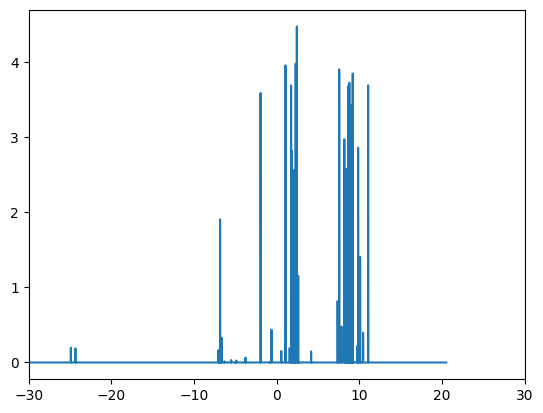

In [81]:
plot(plotrange, ploty)
xlim(-30,30)
show()

## Inference

The typical inference task is to estimate a posterior for
* The number of clusters ($k$)
* The locations of the clusters ($\mu_1, \ldots, \mu_k$)
* Sometimes: the relative weights of those clusters: $p_1, \ldots, p_k$

given
* a dataset of "raw" points; that is, without any information about the underlying clusters.

We'll use our model to simulate a dataset. Then we'll perform posterior inference, and see if we can recover the correct $k$ and $\mu$'s with any confidence.

In [13]:
a = [i for i=1:10]

10-element Array{Int64,1}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10

In [34]:
a = reshape(a, length(a), 1)

10×1 Array{Int64,2}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10

In [36]:
sum()

MethodError: MethodError: no method matching sum(::Array{Int64,2}; axis=1)
Closest candidates are:
  sum(::AbstractArray{#s35,N} where N where #s35<:Number, !Matched::StatsBase.AbstractWeights{#s34,T,V} where V<:AbstractArray{T,1} where T<:Real where #s34<:Real, !Matched::Int64) at /home/dmerrell/.julia/packages/StatsBase/DyWPR/src/weights.jl:483 got unsupported keyword argument "axis"
  sum(::AbstractArray; dims) at reducedim.jl:652 got unsupported keyword argument "axis"
  sum(::AbstractArray, !Matched::StatsBase.AbstractWeights) at /home/dmerrell/.julia/packages/StatsBase/DyWPR/src/weights.jl:280 got unsupported keyword argument "axis"
  ...